In [1]:
import sys
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental")
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet")
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental/backbone-v2")
import os
os.chdir("/data/hpcdata/users/anddon76/icenet/icenet-experimental/")
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from utils import IceNetDataSetPyTorch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2024-07-17 14:30:23.471432: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 14:30:23.521779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 14:30:23.521826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 14:30:23.523427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 14:30:23.538897: I tensorflow/core/platform/cpu_feature_guar

Using device: cuda


In [17]:
import importlib
lightningtrain = importlib.import_module("lightning-train")
model = lightningtrain.LitDiffusion.load_from_checkpoint("results/lightning-diffusion-ddim20-v_prediction-res-True-epoch=5-val_mse=0.0004.ckpt")
dataloader_config = os.path.join("/data/hpcdata/users/anddon76/icenet/icenet-experimental", "dataset_config.single_year_ice_only_lag_two.json")
test_dataset = IceNetDataSetPyTorch(dataloader_config, mode="test", batch_size=4, shuffling=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=0, shuffle=False)


# Sample

In [3]:
residuals_list = []
samples_list = []
means_list = []
stds_list = []
truths_list = []
diffs_list = []

for batch in tqdm(test_dataloader):

    x, y, sample_weight = batch
    x = x.to(model.device)
    y = y.to(model.device)
    sample_weight = sample_weight.to(model.device)

    if model.forecast_residuals:
        y = y - x[:, [0], :, :]  # subtract away most recent ice condition (b, t, h, w)

    bs = x.shape[0]
    mask = torch.where(sample_weight[0] > 0, 1, 0).to(model.device)
    residuals = []
    samples = []
    for i in range(model.num_samples):  # for each condition in batch, generate multiple samples

        noisy_y = torch.randn(bs, model.out_channels,
                                model.resolution, model.resolution).to(model.device)
        model.noise_scheduler.set_timesteps(model.num_inference_timesteps)

        for t in model.noise_scheduler.timesteps:
            with torch.no_grad():
                residual = model.forward(noisy_y, t, x)
            noisy_y = model.noise_scheduler.step(residual, t, noisy_y).prev_sample

        if model.forecast_residuals:
            residuals.append(noisy_y)
            noisy_y = noisy_y + x[:, [0], :, :]  # add on most recent ice condition (b, t, h, w) to THIS PREDICTION

        samples.append(noisy_y)

    if model.forecast_residuals:
        y = y + x[:, [0], :, :]  # add on most recent ice condition (b, t, h, w) to GROUND TRUTH

    samples = torch.stack(samples)  # shape (num_samples, batch_size, timesteps, y, x)
    samples = samples.clip(0, 1)
    samples = samples * mask
    samples_list.append(samples)
    residuals_list.append(residuals)
    means = samples.mean(dim=0)  # take ensemble mean across num_samples dimension
    stds = samples.std(dim=0)  # take ensemble std across num_samples dimension
    diffs = y - means
    means_list.append(means)
    stds_list.append(stds)
    truths_list.append(y)
    diffs_list.append(diffs)
    break


  0%|          | 0/8 [00:00<?, ?it/s]/data/hpcdata/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
  0%|          | 0/8 [00:32<?, ?it/s]


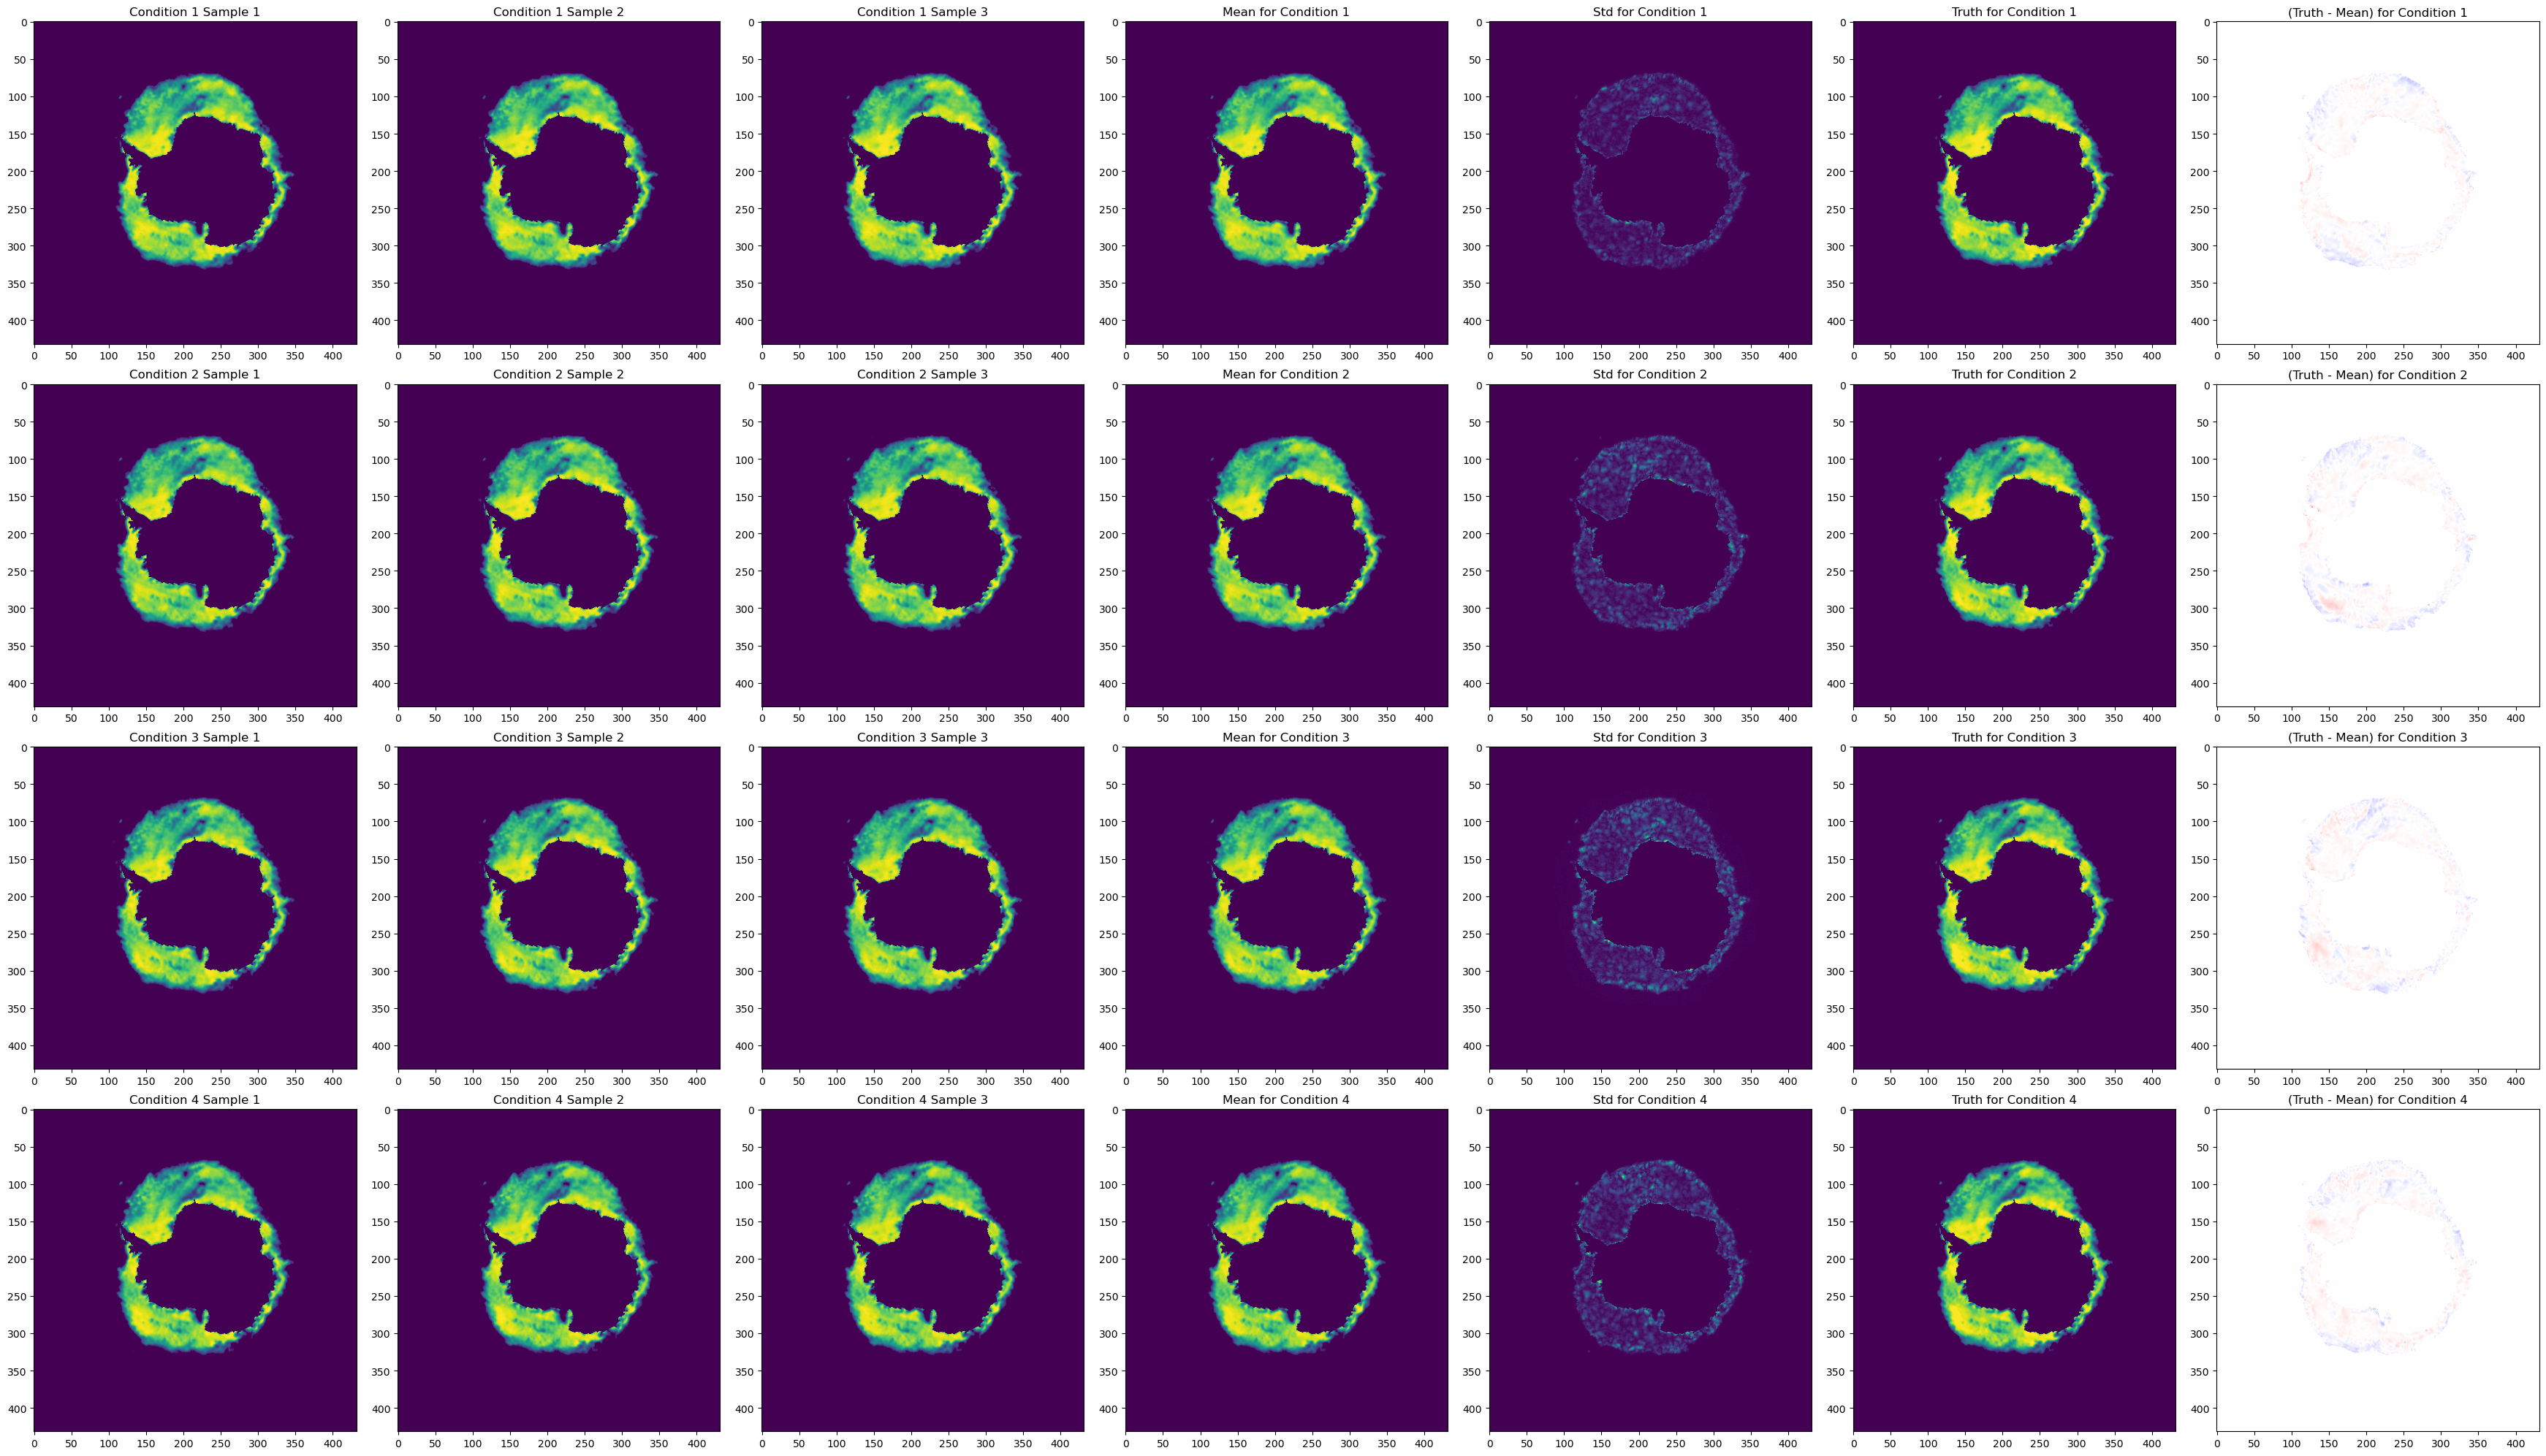

In [4]:
nrows, ncols = bs, model.num_samples + 4
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
for i in range(nrows):
    for j in range(model.num_samples):
        ax[i][j].imshow(samples[j][i].squeeze().cpu())
        ax[i][j].set_title(f"Condition {i+1} Sample {j+1}")
    ax[i][model.num_samples].imshow(means[i].squeeze().cpu())
    ax[i][model.num_samples].set_title(f"Mean for Condition {i+1}")
    ax[i][model.num_samples + 1].imshow(stds[i].squeeze().cpu())
    ax[i][model.num_samples + 1].set_title(f"Std for Condition {i+1}")
    ax[i][model.num_samples + 2].imshow(y[i].squeeze().cpu())
    ax[i][model.num_samples + 2].set_title(f"Truth for Condition {i+1}")
    ax[i][model.num_samples + 3].imshow(diffs[i].squeeze().cpu(), cmap="bwr", vmin=-1, vmax=1)
    ax[i][model.num_samples + 3].set_title(f"(Truth - Mean) for Condition {i+1}")
plt.tight_layout()

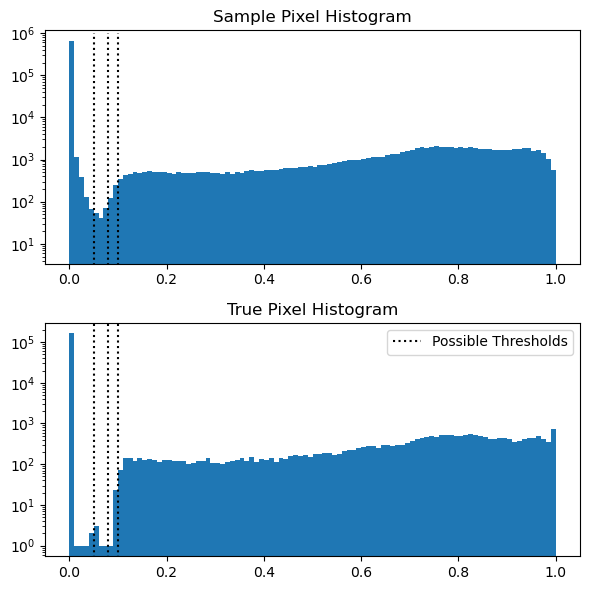

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
thresholds = [0.05, 0.08, 0.1]
ax[0].hist(samples[0].cpu().ravel(), log=True, bins=100)
ax[0].set_title("Sample Pixel Histogram")
ax[0].vlines(thresholds, 0, 1e6, color="black", linestyles="dotted", label="Possible Thresholds")
plt.legend()
ax[1].hist(y[0].cpu().ravel(), log=True, bins=100)
ax[1].set_title("True Pixel Histogram")
ax[1].vlines(thresholds, 0, 1e6, color="black", linestyles="dotted", label="Possible Thresholds")
plt.legend()
plt.tight_layout()

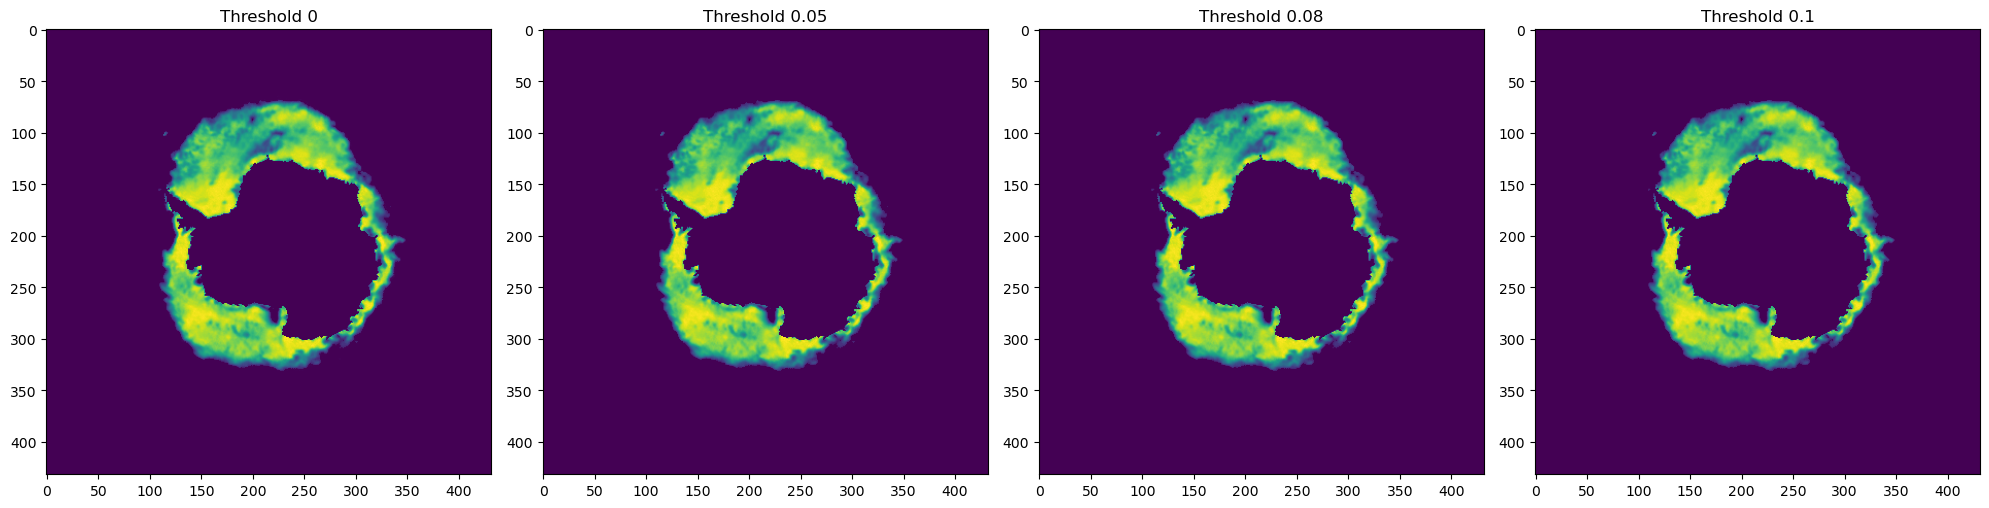

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, threshold in enumerate([0, 0.05, 0.08, 0.1]):
    s = samples[0][0].cpu().squeeze()
    img = torch.where(s < threshold, 0, s)
    ax[i].imshow(img)
    ax[i].set_title(f"Threshold {threshold}")
plt.tight_layout()

In [33]:
truths.shape

torch.Size([31, 1, 432, 432])

In [38]:
truths = torch.vstack(truths_list).cuda()
print("Ensemble Member 1", F.mse_loss(samples[0], truths[:4]))
print("Ensemble Member 2", F.mse_loss(samples[1], truths[:4]))
print("Ensemble Member 3", F.mse_loss(samples[2], truths[:4]))
print("Ensemble Mean", F.mse_loss(means, truths[:4]))
print("Persistence", F.mse_loss(x0[:, 0].cuda(), truths[:4]))
print("Persistence Order 2", F.mse_loss(x0[:, 1].cuda(), truths[:4]))

Ensemble Member 1 tensor(0.0003, device='cuda:0')
Ensemble Member 2 tensor(0.0003, device='cuda:0')
Ensemble Member 3 tensor(0.0003, device='cuda:0')
Ensemble Mean tensor(0.0003, device='cuda:0')
Persistence tensor(0.0005, device='cuda:0')
Persistence Order 2 tensor(0.0007, device='cuda:0')


/tmp/ipykernel_34244/1733352195.py:6: UserWarning: Using a target size (torch.Size([4, 1, 432, 432])) that is different to the input size (torch.Size([4, 432, 432])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print("Persistence", F.mse_loss(x0[:, 0].cuda(), truths[:4]))
/tmp/ipykernel_34244/1733352195.py:7: UserWarning: Using a target size (torch.Size([4, 1, 432, 432])) that is different to the input size (torch.Size([4, 432, 432])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print("Persistence Order 2", F.mse_loss(x0[:, 1].cuda(), truths[:4]))


# Rollouts

In [18]:
truths_list = []
for batch in tqdm(test_dataloader):
    x, y, sw = batch
    truths_list.append(y)
truths = torch.vstack(truths_list).to("cpu")
truths.shape

100%|██████████| 8/8 [00:02<00:00,  3.25it/s]


torch.Size([31, 1, 432, 432])

In [28]:
# let's see how far we can rollout
n = 30
for batch in test_dataloader:
    x0, _, sample_weight = batch
    break
x = x0[[0]].repeat(model.num_samples, 1, 1, 1).to(device)  # copy same x conditions to num_samples size batch
mask = torch.where(sample_weight[0] > 0, 1, 0).to(device)
forecast = []
threshold = 0.01  # minimum SIC below which we set to zero

# iterate over days
for i in tqdm(range(n)):

    # sample
    noisy_y = torch.randn(model.num_samples, 1, 432, 432).to(device)
    for t in model.noise_scheduler.timesteps:
        with torch.no_grad():
            pred = model.forward(noisy_y, t, x)
        noisy_y = model.noise_scheduler.step(pred, t, noisy_y).prev_sample
    
    if model.forecast_residuals:
        noisy_y = noisy_y + x[:, [0]]  # add on most recent ice condition (b, t, h, w) to THIS PREDICTION

    noisy_y = noisy_y.clip(0, 1)  # SIC is bounded between 0 and 1
    noisy_y = noisy_y * mask  # mask out land and midlatitude ocean
    noisy_y = torch.where(noisy_y < threshold, 0, noisy_y)  # clip residual noise
    forecast.append(noisy_y.cpu())
    x = torch.cat((noisy_y, x[:, [0]]), dim=1)  # update to next timestep, t is first, t-1 is second

forecast = torch.cat(forecast, dim=1)  # concatenate along time dimension

100%|██████████| 30/30 [03:56<00:00,  7.90s/it]


In [29]:
from matplotlib.animation import FuncAnimation

def animate(forecast, fpath):
    fps = 3
    fig, ax = plt.subplots(2, 4, figsize=(20, 11))
    ax = ax.ravel()

    def update(step):
        fc_1.set_data(forecast[0].squeeze()[step].numpy())
        fc_2.set_data(forecast[1].squeeze()[step].numpy())
        fc_3.set_data(forecast[2].squeeze()[step].numpy())
        fc_std.set_data(forecast.std(dim=0).squeeze()[step].numpy())
        fc_mean.set_data(forecast.mean(dim=0).squeeze()[step].numpy())
        fc_true.set_data(truths[step].squeeze().numpy())
        fc_diff.set_data((truths[step].squeeze() - forecast.mean(dim=0)[step]).numpy())
        n, _ = np.histogram(forecast[0].squeeze()[step].numpy().ravel(), 100)
        for count, rect in zip(n, fc_hist.patches):
            rect.set_height(count)
        title.set_text(f"Rollout Step {step+1}")
        return fc_1, fc_2, fc_3, fc_std, fc_mean, fc_true, fc_diff, fc_hist, title

    fc_1 = ax[0].imshow(forecast[0].squeeze()[0].numpy(), vmin=0, vmax=1, animated=True)
    ax[0].set_title("Ensemble Member 1")
    fc_2 = ax[1].imshow(forecast[1].squeeze()[0].numpy(), vmin=0, vmax=1, animated=True)
    ax[1].set_title("Ensemble Member 2")
    fc_3 = ax[2].imshow(forecast[2].squeeze()[0].numpy(), vmin=0, vmax=1, animated=True)
    ax[2].set_title("Ensemble Member 3")
    fc_std = ax[3].imshow(forecast.std(dim=0).squeeze()[0].numpy(), cmap="cividis", animated=True)
    ax[3].set_title("Ensemble Std")
    fc_mean = ax[4].imshow(forecast.mean(dim=0).squeeze()[0].numpy(), vmin=0, vmax=1, animated=True)
    ax[4].set_title("Ensemble Mean")
    fc_true = ax[5].imshow(truths[0].squeeze().numpy(), vmin=0, vmax=1, animated=True)
    ax[5].set_title("Truth")
    fc_diff = ax[6].imshow((truths[0].squeeze() - forecast.mean(dim=0)[0]).numpy(), vmin=-1, vmax=1, cmap="bwr", animated=True)
    ax[6].set_title("(Truth - Ensemble Mean)")
    _, _, fc_hist = ax[7].hist(forecast[0].squeeze()[0].numpy().ravel(), bins=100, log=True)
    ax[7].set_title("Histogram of Ensemble Member 1")
    title = plt.suptitle("Rollout Step 1")
    plt.tight_layout()

    animation = FuncAnimation(fig, update, range(30), interval=1000 / fps)
    plt.close()
    animation.save(fpath, fps=fps)

In [30]:
title = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/results/ddim-v-pred-rollout-res-{model.forecast_residuals}-clip-{threshold}.mp4"
animate(forecast, title)

In [ ]:
# rollout with backwards concatenation
# let's see how far we can rollout
n = 30
for batch in test_dataloader:
    x0, _, sample_weight = batch
    break
x = x0[[0]].repeat(model.num_samples, 1, 1, 1).to(device)  # copy same x conditions to num_samples size batch
mask = torch.where(sample_weight[0] > 0, 1, 0).to(device)
rforecast = []
threshold = 0.01  # minimum SIC below which we set to zero

# iterate over days
for i in tqdm(range(n)):

    # sample
    noisy_y = torch.randn(model.num_samples, 1, 432, 432).to(device)
    for t in model.noise_scheduler.timesteps:
        with torch.no_grad():
            pred = model.forward(noisy_y, t, x)
        noisy_y = model.noise_scheduler.step(pred, t, noisy_y).prev_sample
    
    noisy_y = noisy_y.clip(0, 1)  # SIC is bounded between 0 and 1
    noisy_y = noisy_y * mask  # mask out land and midlatitude ocean
    noisy_y = torch.where(noisy_y < threshold, 0, noisy_y)  # clip residual noise
    rforecast.append(noisy_y.cpu())
    x = torch.cat((x[:, [1]], noisy_y), dim=1)  # update to next timestep, REVERSED

rforecast = torch.cat(rforecast, dim=1)  # concatenate along time dimension

In [164]:
rtitle = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/results/ddim-v-pred-rev-rollout-clip-{threshold}.mp4"
animate(rforecast, rtitle)

In [166]:
# rollout with in distribution dataset
train_dataset = IceNetDataSetPyTorch(dataloader_config, mode="train", batch_size=4, shuffling=False)
train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=False)
truths_list = []
for i, batch in enumerate(train_dataloader):
    x, y, sw = batch
    truths_list.append(y)
    if i == 7:
        break
truths = torch.vstack(truths_list).to("cpu")
truths.shape

torch.Size([36, 1, 432, 432])

In [167]:
# let's see how far we can rollout
n = 30
for batch in train_dataloader:
    x0, _, sample_weight = batch
    break
x = x0[[0]].repeat(model.num_samples, 1, 1, 1).to(device)  # copy same x conditions to num_samples size batch
mask = torch.where(sample_weight[0] > 0, 1, 0).to(device)
forecast = []
threshold = 0.01  # minimum SIC below which we set to zero

# iterate over days
for i in tqdm(range(n)):

    # sample
    noisy_y = torch.randn(model.num_samples, 1, 432, 432).to(device)
    for t in model.noise_scheduler.timesteps:
        with torch.no_grad():
            pred = model.forward(noisy_y, t, x)
        noisy_y = model.noise_scheduler.step(pred, t, noisy_y).prev_sample
    
    noisy_y = noisy_y.clip(0, 1)  # SIC is bounded between 0 and 1
    noisy_y = noisy_y * mask  # mask out land and midlatitude ocean
    noisy_y = torch.where(noisy_y < threshold, 0, noisy_y)  # clip residual noise
    forecast.append(noisy_y.cpu())
    x = torch.cat((noisy_y, x[:, [0]]), dim=1)  # update to next timestep

forecast = torch.cat(forecast, dim=1)  # concatenate along time dimension

100%|██████████| 30/30 [03:56<00:00,  7.89s/it]


In [168]:
title = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/results/ddim-v-pred-trainset-rollout-clip-{threshold}.mp4"
animate(forecast, title)

In [170]:
# rollout with in distribution dataset
val_dataset = IceNetDataSetPyTorch(dataloader_config, mode="val", batch_size=4, shuffling=False)
val_dataloader = DataLoader(val_dataset, batch_size=4, num_workers=0, shuffle=False)
truths_list = []
for i, batch in enumerate(val_dataloader):
    x, y, sw = batch
    truths_list.append(y)
    if i == 7:
        break
truths = torch.vstack(truths_list).to("cpu")
truths.shape

torch.Size([30, 1, 432, 432])

In [171]:
# let's see how far we can rollout
n = 30
for batch in val_dataloader:
    x0, _, sample_weight = batch
    break
x = x0[[0]].repeat(model.num_samples, 1, 1, 1).to(device)  # copy same x conditions to num_samples size batch
mask = torch.where(sample_weight[0] > 0, 1, 0).to(device)
forecast = []
threshold = 0.01  # minimum SIC below which we set to zero

# iterate over days
for i in tqdm(range(n)):

    # sample
    noisy_y = torch.randn(model.num_samples, 1, 432, 432).to(device)
    for t in model.noise_scheduler.timesteps:
        with torch.no_grad():
            pred = model.forward(noisy_y, t, x)
        noisy_y = model.noise_scheduler.step(pred, t, noisy_y).prev_sample
    
    noisy_y = noisy_y.clip(0, 1)  # SIC is bounded between 0 and 1
    noisy_y = noisy_y * mask  # mask out land and midlatitude ocean
    noisy_y = torch.where(noisy_y < threshold, 0, noisy_y)  # clip residual noise
    forecast.append(noisy_y.cpu())
    x = torch.cat((noisy_y, x[:, [0]]), dim=1)  # update to next timestep

forecast = torch.cat(forecast, dim=1)  # concatenate along time dimension

100%|██████████| 30/30 [03:56<00:00,  7.89s/it]


In [172]:
title = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/results/ddim-v-pred-valset-rollout-clip-{threshold}.mp4"
animate(forecast, title)